Acurácia do modelo: 0.41


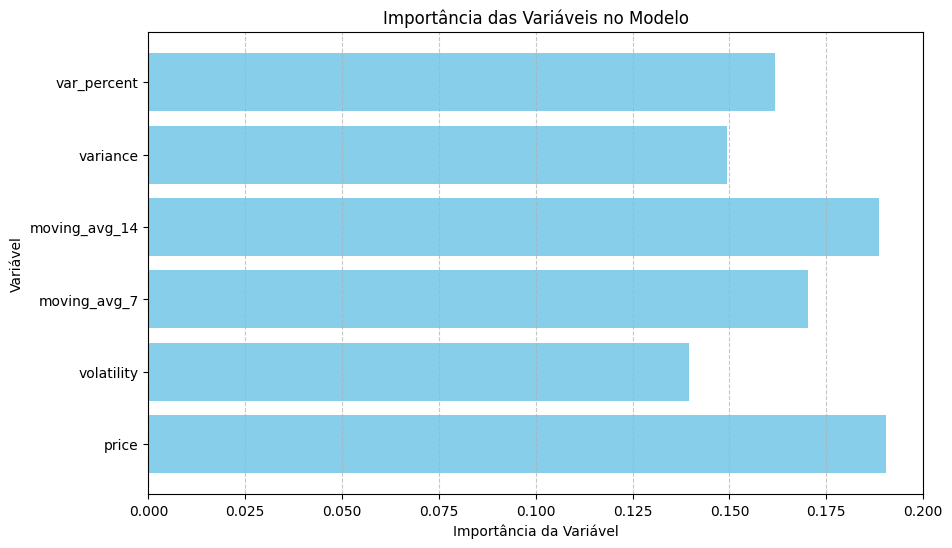

In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Passo 2: Coletar Dados Históricos da API CoinGecko
def fetch_historical_data(coin_id, days):
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': days
    }
    response = requests.get(url, params=params)
    data = response.json()
    prices = data['prices']
    df = pd.DataFrame(prices, columns=['timestamp', 'price'])
    df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop(columns=['timestamp'])
    return df

# Coletar dados históricos de Bitcoin para os últimos 365 dias
coin_id = 'bitcoin'
days = '365'
data = fetch_historical_data(coin_id, days)

# Passo 3: Preparar os Dados
data['next_day_price'] = data['price'].shift(-1)
data['target'] = np.where(data['next_day_price'] > data['price'], 1, 0)

# Criar variáveis adicionais
data['volatility'] = data['price'].rolling(window=7).std()
data['moving_avg_7'] = data['price'].rolling(window=7).mean()
data['moving_avg_14'] = data['price'].rolling(window=14).mean()
data['variance'] = data['price'].rolling(window=7).var()
data['var_percent'] = data['variance'] / data['price']

# Remover a última linha que não tem valor para 'next_day_price'
data = data.dropna()

# Passo 4: Dividir os Dados em Treino e Teste
X = data[['price', 'volatility', 'moving_avg_7', 'moving_avg_14', 'variance', 'var_percent']]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 5: Treinar o Modelo de Aprendizado de Máquina
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo: {accuracy:.2f}')

# Passo 6: Visualizar a Importância das Variáveis
importances = model.feature_importances_
feature_names = X.columns

# Criar um gráfico de barras para a importância das variáveis
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importância da Variável')
plt.ylabel('Variável')
plt.title('Importância das Variáveis no Modelo')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Passo 7: Salvar os Dados em um Arquivo CSV
data.to_csv('historical_bitcoin_prices.csv', index=False)